# 🔰PyTorchでニューラルネットワーク基礎 #07【中間層特徴量の抽出 2】

### 内容
* [Qiita](https://qiita.com/AzukiImo/items/63c491683ed52927f909)の記事と連動しています
* VGG16を利用した画像分類のサンプル
* VGG16の中間層の出力値を取得、可視化

### データについて
* データ：data/lion.jpg
* 画像データは[正面から見たライオンの写真素材フリー](https://www.kenpo21.com/large/zoo24_jpg.html)を使わせていただきました。
* ImageNetのラベルファイル：data/imagenet.json

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.models import vgg16, VGG16_Weights
from PIL import Image
import matplotlib.pyplot as plt
import japanize_matplotlib
import json

In [2]:
# ImageNetで学習済みの重みを持つVGG16モデルをロード
weights = VGG16_Weights.IMAGENET1K_V1
model = vgg16(weights=weights)

# 前処理も一緒に取得
preprocess = weights.transforms()

In [3]:
with open("./data/imagenet.json", "rt") as file:
        labels = json.load(file)

In [4]:
# ラベルを確認してみた
labels["0"]

'tench'

### 画像の前処理のための変換を定義
[PyTorch VGG16の詳細](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html)


preprocess = weights.transforms()の詳細
~~~
preprocess = transforms.Compose([
    transforms.Resize(256),            # 画像を256x256にリサイズ
    transforms.CenterCrop(224),        # 中央を224x224に切り抜く
    transforms.ToTensor(),             # PyTorchテンソルに変換 (0-255 -> 0-1)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #正規化
])
~~~

## ライオンの画像で動作を確認する

In [5]:
sample_image = Image.open("./data/lion.jpg").convert("RGB")  # 画像のロード
input_tensor = preprocess(sample_image)  # 画像の前処理 -> shape: (3, 224, 224)
input_batch = input_tensor.unsqueeze(0)  # shape: (1, 3, 224, 224)

In [6]:
model.eval()

# GPUが利用可能であればGPUへ
if torch.cuda.is_available():
    input_batch = input_batch.to("cuda")
    model.to("cuda")
with torch.inference_mode():
    output = model(input_batch)
# 確率に変換
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# 最も確率の高い上位3つのクラスを表示
top3_prob, top3_id = torch.topk(probabilities, 3)
top3_prob, top3_id

(tensor([9.9957e-01, 3.7367e-04, 2.3764e-05], device='cuda:0'),
 tensor([291, 260, 292], device='cuda:0'))

In [7]:
# ラベルで示してみた
for num, id in enumerate(top3_id):
    print(f"{num+1}位: {labels[str(id.cpu().numpy())]}")

1位: lion
2位: chow
3位: tiger


# 中間層の値を習得する

### 1. modelのネットワーク名を知る
### 2. register_forward_hook()
### 3. 可視化

In [8]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## ネットワーク名が取得できているのか確認

In [9]:
model.features[0], model.features[1], model.features[2], model.features[3], model.features[4]

(Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False))

## 中間層の出力を可視化

In [9]:
feature_maps = {}
def register_activation_hook(name):
    def hook(module, input, output):
        feature_maps[name] = output.detach()
    return hook

# 抽出するネットワーク名を登録する
hooks = []
hooks.append(model.features[0].register_forward_hook(register_activation_hook("conv1_1")))
hooks.append(model.features[28].register_forward_hook(register_activation_hook("conv5_3")))
hooks.append(model.features[30].register_forward_hook(register_activation_hook("maxpool_5")))

## サンプル画像で中間層の出力値を可視化
* 動作確認を実行している場合は下記を実行しなくてもOK

In [10]:
sample_image = Image.open("./data/lion.jpg").convert("RGB")  # 画像のロード
input_tensor = preprocess(sample_image)  # 画像の前処理 -> shape: (3, 224, 224)
input_batch = input_tensor.unsqueeze(0)  # shape: (1, 3, 224, 224)

# 推論
model.eval()
# GPUが利用可能であればGPUへ
if torch.cuda.is_available():
    input_batch = input_batch.to("cuda")
    model.to("cuda")

with torch.inference_mode():
    output = model(input_batch)

## CNN1-1出力可視化

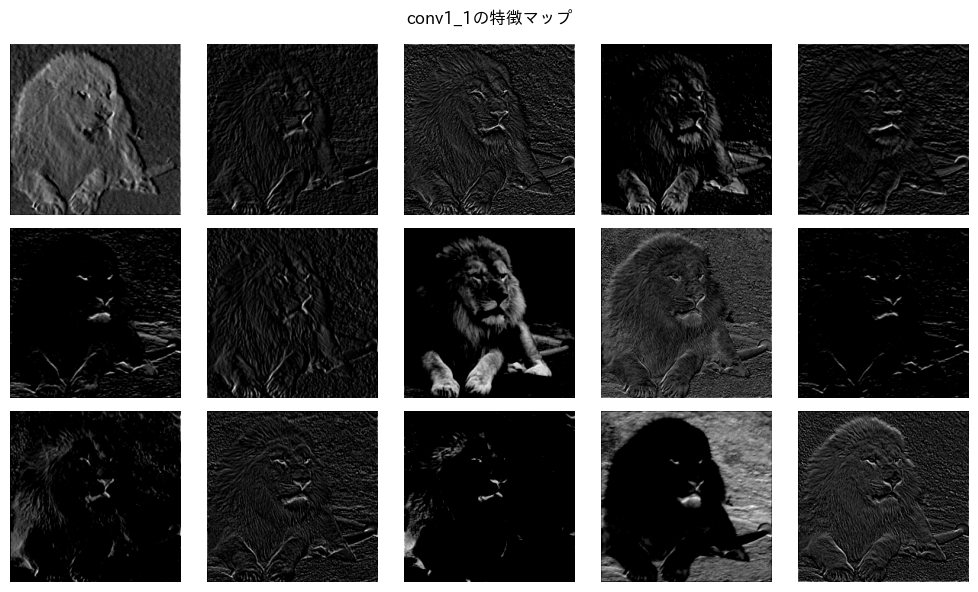

In [11]:
network_name = "conv1_1"

feature_map = feature_maps[network_name].squeeze().cpu().numpy()

fig, axes = plt.subplots(3, 5, figsize=(10, 6))
plt.suptitle(network_name+"の特徴マップ")
for i, ax in enumerate(axes.flat):
    ax.imshow(feature_map[i], cmap="gray")
    ax.axis('off')
plt.tight_layout()
plt.show()


## CNN5-3出力可視化
* 最後のCNN出力
* 画像の順番は、最初のCNN出力の画像と対応しているわけではない

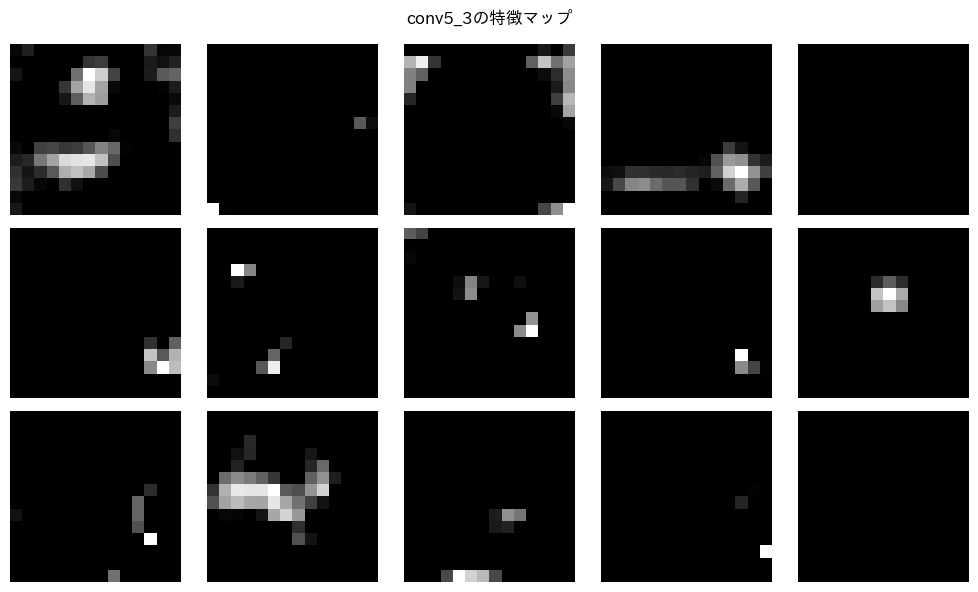

In [12]:
network_name = "conv5_3"

feature_map = feature_maps[network_name].squeeze().cpu().numpy()

fig, axes = plt.subplots(3, 5, figsize=(10, 6))
plt.suptitle(network_name+"の特徴マップ")
for i, ax in enumerate(axes.flat):
    ax.imshow(feature_map[i], cmap="gray")
    ax.axis('off')
plt.tight_layout()
plt.show()

## MaxPoolの出力可視化

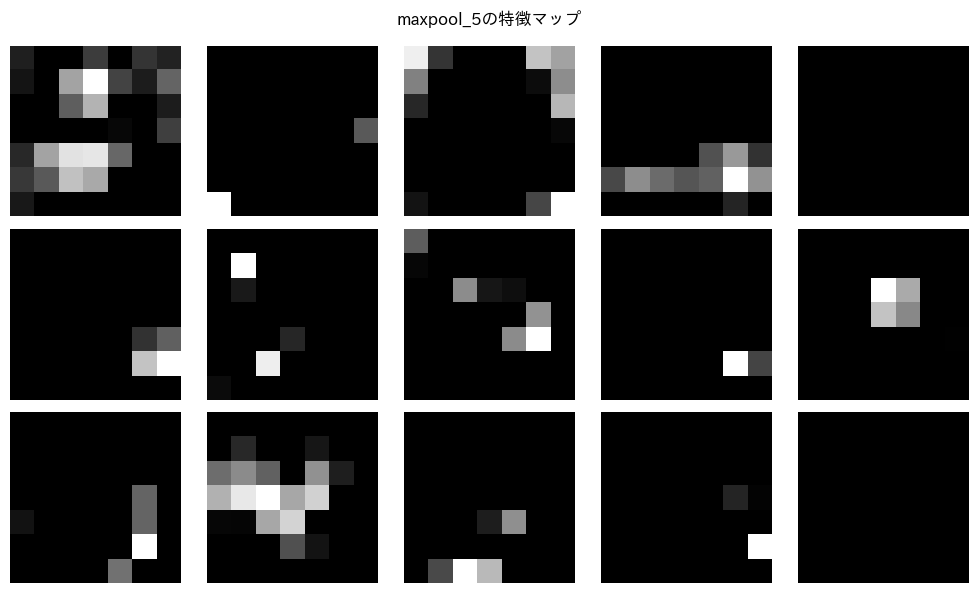

In [13]:
network_name = "maxpool_5"

feature_map = feature_maps[network_name].squeeze().cpu().numpy()

fig, axes = plt.subplots(3, 5, figsize=(10, 6))
plt.suptitle(network_name+"の特徴マップ")
for i, ax in enumerate(axes.flat):
    ax.imshow(feature_map[i], cmap="gray")
    ax.axis('off')
plt.tight_layout()
plt.show()
